# SELECCIÓN DE CARACTERÍSTICAS <br>

En este apartado se aplicarán técnicas de selección de características para seleccionar aquellas que devuelven mejores resultados.<br>

- Importamos las _librerías_ necesarias:<br>

In [8]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

- __Directorios__ utilizados:<br>

In [9]:
PROJECT_ROOT_PATH = "."
DATASETS_PATH = PROJECT_ROOT_PATH + os.sep + "datasets"
FINAL_DATASETS_PATH = PROJECT_ROOT_PATH + os.sep + "final_datasets"
MODELS_PATH = PROJECT_ROOT_PATH + os.sep + "modelos"

## Recogida de datos<br>

- Con la siguiente función leemos cada fichero CSV y devolvemos un _DataFrame_:<br>

In [10]:
def load_data(filename, separator, folder, path=FINAL_DATASETS_PATH):
    file_path = os.path.join(path, folder + os.sep + filename)
    return pd.read_csv(file_path, sep=separator)

In [11]:
df_train = load_data("6_train_dataset.csv",',', "6_preprocesado_datos")

***
## Método 1 extracción características<br>

### Técnica 1: Correlación: <br>

<AxesSubplot:>

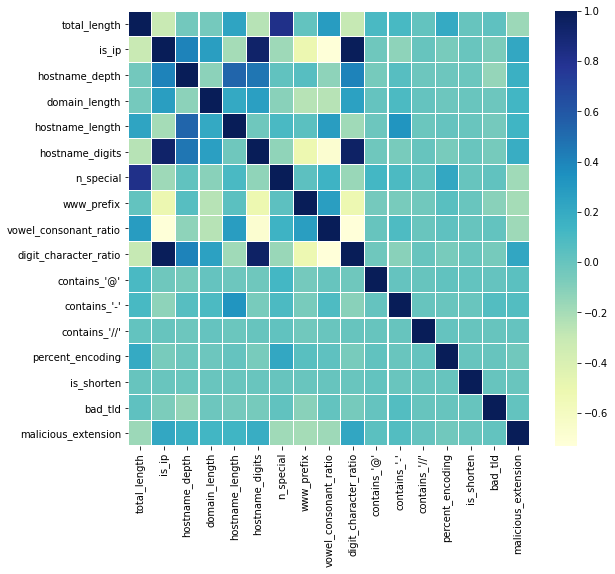

In [5]:
df_train_no_label = df_train.drop(["label"], axis=1) 
corrmat = df_train_no_label.corr() 
  
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

- Eliminamos características muy correlacionadas:<br>

In [6]:
df_train = df_train.drop(["is_ip", "hostname_digits","total_length"], axis=1) 

<AxesSubplot:>

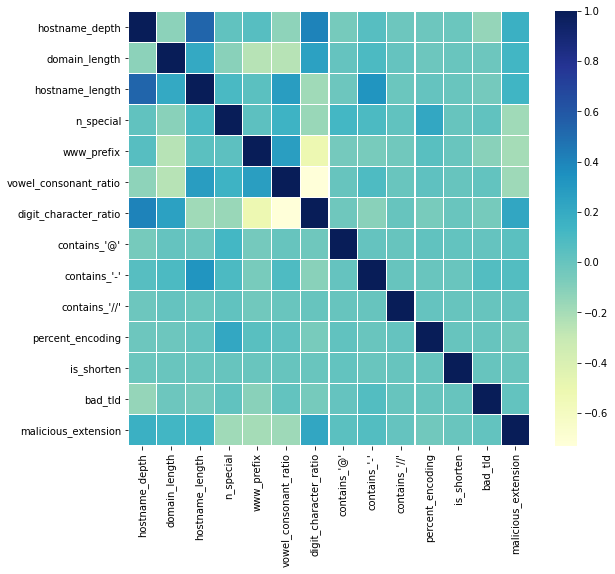

In [7]:
df_train_no_label = df_train.drop(["label"], axis=1) 
corrmat = df_train_no_label.corr() 
  
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

***
## Método 2 Bolsa de Palabras<br>

- Importamos la libreria de CountVectorizer y las necesarias para evaluar los modelos: <br>

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

- Cargamos los datos obtenidos tras separar cada URL en sus respectivas partes: <br>

In [13]:
SUBFOLDER_METHOD_2 = "4_extraccion_caracteristicas" + os.sep + "metodo_2"

df_train = load_data("4_2_parts_train.csv",',', SUBFOLDER_METHOD_2)
print(len(df_train))
df_train.head()

483977


,protocolo,subdominio,dominio,tld,path,query,label
0,https,www.athletics,mta,ca,/varsity/football/cfl.html,NaN,0
1,https,drive,google,com,/file/d/1uis0mbfzg1vrxxg2ka2l18q9pdyrmqv8,NaN,1
2,http,NaN,xmotor,ir,/localization/closed_section/verified_area/752...,NaN,1
3,https,www.en,wikipedia,org,/wiki/papineau_(montreal_metro),NaN,0
4,https,www.eddiecibrian-actor,blogspot,com,/,NaN,0


In [14]:
df_train['protocolo'] = df_train['protocolo'].fillna('')
df_train['subdominio'] = df_train['subdominio'].fillna('')
df_train['dominio'] = df_train['dominio'].fillna('')
df_train['tld'] = df_train['tld'].fillna('')
df_train['path'] = df_train['path'].fillna('')
df_train['query'] = df_train['query'].fillna('')

***
- Por cada parte de la URL seleccionamos un conjunto de características diferentes y observamos su resultado: <br>

1. Subdominio: <br>

In [23]:
max_features = [10,50,100,500,1000]

for n in max_features:
    
    print("***************************************")
    print("***** NÚMERO CARACTERÍSTICAS: " + str(n))
    print("***************************************")
    
    clf = Pipeline(
        [('c_vect',CountVectorizer(ngram_range=(1,2), min_df=50, token_pattern=r'[a-zA-Z]{2,}', max_features=n,binary=True)),
            ('lr', LogisticRegression(solver = 'lbfgs', max_iter=2000))
        ]
    )

    X_train = df_train['subdominio']
    y_train = df_train['label']

    k_fold = KFold(n_splits=5, shuffle = True, random_state=150)
    y_train_pred = cross_val_predict(clf, X_train, y_train, cv= k_fold)
    
    cm = confusion_matrix(y_train, y_train_pred)
    print(cm)
    tn, fp, fn, tp = cm.ravel()
    print("True Positives: " + str(tp))
    print("True Negatives: " + str(tn))
    print("False Positives: " + str(fp))
    print("False Negatives: " + str(fn))
    print(classification_report(y_train, y_train_pred))
    accuracy = accuracy_score(y_train, y_train_pred)
    print('Puntuación: ' + str(accuracy))
    f1 = f1_score(y_train, y_train_pred)
    print("F1_score: " + str(f1))
    precision = tp / (tp + fp)
    print("Precisión: " + str(precision))
    recall = tp / (tp + fn)
    print("Recall: " + str(recall))
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    print("TPR: " + str(tpr))
    print("FPR: " + str(fpr))
    auc = roc_auc_score(y_train, y_train_pred)
    print("AUC: " + str(auc))
    #La siguiente linea para integrar en la memoria en Latex
    print(str(n) + " & " + str(round(accuracy*100,4)) +  " & " + str(round(f1*100,4)) +  " & " + str(round(precision*100,4)) +  " & " + str(round(recall*100,4))  +  " & " + str(round(auc*100,5)) +  " \\\\ \hline" )
    print("*****************************************************************")
    print("\n")

***************************************
***** NÚMERO CARACTERÍSTICAS: 10
***************************************
[[241490    498]
 [ 22040 219949]]
True Positives: 219949
True Negatives: 241490
False Positives: 498
False Negatives: 22040
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    241988
           1       1.00      0.91      0.95    241989

    accuracy                           0.95    483977
   macro avg       0.96      0.95      0.95    483977
weighted avg       0.96      0.95      0.95    483977

Puntuación: 0.9534316713397537
F1_score: 0.9512624449653573
Precisión: 0.9977409536078967
Recall: 0.908921479901979
TPR: [0.         0.90892148 1.        ]
FPR: [0.         0.00205795 1.        ]
AUC: 0.9534317633075196
10 & 95.3432 & 95.1262 & 99.7741 & 90.8921 & 95.34318 \\ \hline
*****************************************************************


***************************************
***** NÚMERO CARACTERÍSTICAS: 50
**********

2. Dominio: <br>

In [24]:
max_features = [10,50,100,500,1000]

for n in max_features:
    
    print("***************************************")
    print("***** NÚMERO CARACTERÍSTICAS: " + str(n))
    print("***************************************")
    
    clf = Pipeline(
        [('c_vect',CountVectorizer(ngram_range=(1,2), min_df=50, token_pattern=r'[a-zA-Z]{2,}', max_features=n,binary=True)),
            ('lr', LogisticRegression(solver = 'lbfgs', max_iter=2000))
        ]
    )

    X_train = df_train['dominio']
    y_train = df_train['label']

    k_fold = KFold(n_splits=5, shuffle = True, random_state=150)
    y_train_pred = cross_val_predict(clf, X_train, y_train, cv= k_fold)
    
    cm = confusion_matrix(y_train, y_train_pred)
    print(cm)
    tn, fp, fn, tp = cm.ravel()
    print("True Positives: " + str(tp))
    print("True Negatives: " + str(tn))
    print("False Positives: " + str(fp))
    print("False Negatives: " + str(fn))
    print(classification_report(y_train, y_train_pred))
    accuracy = accuracy_score(y_train, y_train_pred)
    print('Puntuación: ' + str(accuracy))
    f1 = f1_score(y_train, y_train_pred)
    print("F1_score: " + str(f1))
    precision = tp / (tp + fp)
    print("Precisión: " + str(precision))
    recall = tp / (tp + fn)
    print("Recall: " + str(recall))
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    print("TPR: " + str(tpr))
    print("FPR: " + str(fpr))
    auc = roc_auc_score(y_train, y_train_pred)
    print("AUC: " + str(auc))
    #La siguiente linea para integrar en la memoria en Latex
    print(str(n) + " & " + str(round(accuracy*100,4)) +  " & " + str(round(f1*100,4)) +  " & " + str(round(precision*100,4)) +  " & " + str(round(recall*100,4))  +  " & " + str(round(auc*100,5)) +  " \\\\ \hline" )
    print("*****************************************************************")
    print("\n")

***************************************
***** NÚMERO CARACTERÍSTICAS: 10
***************************************
[[ 38209 203779]
 [   145 241844]]
True Positives: 241844
True Negatives: 38209
False Positives: 203779
False Negatives: 145
              precision    recall  f1-score   support

           0       1.00      0.16      0.27    241988
           1       0.54      1.00      0.70    241989

    accuracy                           0.58    483977
   macro avg       0.77      0.58      0.49    483977
weighted avg       0.77      0.58      0.49    483977

Puntuación: 0.5786493986284472
F1_score: 0.7034315864179217
Precisión: 0.5427098691046018
Recall: 0.9994007992098815
TPR: [0.        0.9994008 1.       ]
FPR: [0.         0.84210374 1.        ]
AUC: 0.5786485292642627
10 & 57.8649 & 70.3432 & 54.271 & 99.9401 & 57.86485 \\ \hline
*****************************************************************


***************************************
***** NÚMERO CARACTERÍSTICAS: 50
*************

3. TLD: <br>

In [25]:
max_features = [10,50,100,500,1000]

for n in max_features:
    
    print("***************************************")
    print("***** NÚMERO CARACTERÍSTICAS: " + str(n))
    print("***************************************")
    
    clf = Pipeline(
        [('c_vect',CountVectorizer(ngram_range=(1,1), min_df=50, token_pattern=r'[a-zA-Z]{2,}', max_features=n,binary=True)),
            ('lr', LogisticRegression(solver = 'lbfgs', max_iter=2000))
        ]
    )

    X_train = df_train['tld']
    y_train = df_train['label']

    k_fold = KFold(n_splits=5, shuffle = True, random_state=150)
    y_train_pred = cross_val_predict(clf, X_train, y_train, cv= k_fold)
    
    cm = confusion_matrix(y_train, y_train_pred)
    print(cm)
    tn, fp, fn, tp = cm.ravel()
    print("True Positives: " + str(tp))
    print("True Negatives: " + str(tn))
    print("False Positives: " + str(fp))
    print("False Negatives: " + str(fn))
    print(classification_report(y_train, y_train_pred))
    accuracy = accuracy_score(y_train, y_train_pred)
    print('Puntuación: ' + str(accuracy))
    f1 = f1_score(y_train, y_train_pred)
    print("F1_score: " + str(f1))
    precision = tp / (tp + fp)
    print("Precisión: " + str(precision))
    recall = tp / (tp + fn)
    print("Recall: " + str(recall))
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    print("TPR: " + str(tpr))
    print("FPR: " + str(fpr))
    auc = roc_auc_score(y_train, y_train_pred)
    print("AUC: " + str(auc))
    #La siguiente linea para integrar en la memoria en Latex
    print(str(n) + " & " + str(round(accuracy*100,4)) +  " & " + str(round(f1*100,4)) +  " & " + str(round(precision*100,4)) +  " & " + str(round(recall*100,4))  +  " & " + str(round(auc*100,5)) +  " \\\\ \hline" )
    print("*****************************************************************")
    print("\n")

***************************************
***** NÚMERO CARACTERÍSTICAS: 10
***************************************
[[233634   8354]
 [109327 132662]]
True Positives: 132662
True Negatives: 233634
False Positives: 8354
False Negatives: 109327
              precision    recall  f1-score   support

           0       0.68      0.97      0.80    241988
           1       0.94      0.55      0.69    241989

    accuracy                           0.76    483977
   macro avg       0.81      0.76      0.75    483977
weighted avg       0.81      0.76      0.75    483977

Puntuación: 0.7568458831721342
F1_score: 0.6927429145833606
Precisión: 0.9407584954898734
Recall: 0.548215001508333
TPR: [0.       0.548215 1.      ]
FPR: [0.         0.03452237 1.        ]
AUC: 0.7568463142490506
10 & 75.6846 & 69.2743 & 94.0758 & 54.8215 & 75.68463 \\ \hline
*****************************************************************


***************************************
***** NÚMERO CARACTERÍSTICAS: 50
**************

4. Path: <br>

In [26]:
max_features = [10,50,100,500,1000]

for n in max_features:
    
    print("***************************************")
    print("***** NÚMERO CARACTERÍSTICAS: " + str(n))
    print("***************************************")
    
    clf = Pipeline(
        [('c_vect',CountVectorizer(ngram_range=(1,3), min_df=50, token_pattern=r'[a-zA-Z]{2,}', max_features=n,binary=True)),
            ('lr', LogisticRegression(solver = 'lbfgs', max_iter=2000))
        ]
    )

    X_train = df_train['path']
    y_train = df_train['label']

    k_fold = KFold(n_splits=5, shuffle = True, random_state=150)
    y_train_pred = cross_val_predict(clf, X_train, y_train, cv= k_fold)
    
    cm = confusion_matrix(y_train, y_train_pred)
    print(cm)
    tn, fp, fn, tp = cm.ravel()
    print("True Positives: " + str(tp))
    print("True Negatives: " + str(tn))
    print("False Positives: " + str(fp))
    print("False Negatives: " + str(fn))
    print(classification_report(y_train, y_train_pred))
    accuracy = accuracy_score(y_train, y_train_pred)
    print('Puntuación: ' + str(accuracy))
    f1 = f1_score(y_train, y_train_pred)
    print("F1_score: " + str(f1))
    precision = tp / (tp + fp)
    print("Precisión: " + str(precision))
    recall = tp / (tp + fn)
    print("Recall: " + str(recall))
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    print("TPR: " + str(tpr))
    print("FPR: " + str(fpr))
    auc = roc_auc_score(y_train, y_train_pred)
    print("AUC: " + str(auc))
    #La siguiente linea para integrar en la memoria en Latex
    print(str(n) + " & " + str(round(accuracy*100,4)) +  " & " + str(round(f1*100,4)) +  " & " + str(round(precision*100,4)) +  " & " + str(round(recall*100,4))  +  " & " + str(round(auc*100,5)) +  " \\\\ \hline" )
    print("*****************************************************************")
    print("\n")

***************************************
***** NÚMERO CARACTERÍSTICAS: 10
***************************************
[[231275  10713]
 [133031 108958]]
True Positives: 108958
True Negatives: 231275
False Positives: 10713
False Negatives: 133031
              precision    recall  f1-score   support

           0       0.63      0.96      0.76    241988
           1       0.91      0.45      0.60    241989

    accuracy                           0.70    483977
   macro avg       0.77      0.70      0.68    483977
weighted avg       0.77      0.70      0.68    483977

Puntuación: 0.7029941505484765
F1_score: 0.6025438256926394
Precisión: 0.9104795648068454
Recall: 0.4502601357912963
TPR: [0.         0.45026014 1.        ]
FPR: [0.         0.04427079 1.        ]
AUC: 0.7029946727520873
10 & 70.2994 & 60.2544 & 91.048 & 45.026 & 70.29947 \\ \hline
*****************************************************************


***************************************
***** NÚMERO CARACTERÍSTICAS: 50
********

5. Query: <br>

In [15]:
max_features = [10,50,100,500,1000]

for n in max_features:
    
    print("***************************************")
    print("***** NÚMERO CARACTERÍSTICAS: " + str(n))
    print("***************************************")
    
    clf = Pipeline(
        [('c_vect',CountVectorizer(ngram_range=(1,3), min_df=50, token_pattern=r'[a-zA-Z]{2,}', max_features=n,binary=True)),
            ('lr', LogisticRegression(solver = 'lbfgs', max_iter=2000))
        ]
    )

    X_train = df_train['query']
    y_train = df_train['label']

    k_fold = KFold(n_splits=5, shuffle = True, random_state=150)
    y_train_pred = cross_val_predict(clf, X_train, y_train, cv= k_fold)
    
    cm = confusion_matrix(y_train, y_train_pred)
    print(cm)
    tn, fp, fn, tp = cm.ravel()
    print("True Positives: " + str(tp))
    print("True Negatives: " + str(tn))
    print("False Positives: " + str(fp))
    print("False Negatives: " + str(fn))
    print(classification_report(y_train, y_train_pred))
    accuracy = accuracy_score(y_train, y_train_pred)
    print('Puntuación: ' + str(accuracy))
    f1 = f1_score(y_train, y_train_pred)
    print("F1_score: " + str(f1))
    precision = tp / (tp + fp)
    print("Precisión: " + str(precision))
    recall = tp / (tp + fn)
    print("Recall: " + str(recall))
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    print("TPR: " + str(tpr))
    print("FPR: " + str(fpr))
    auc = roc_auc_score(y_train, y_train_pred)
    print("AUC: " + str(auc))
    #La siguiente linea para integrar en la memoria en Latex
    print(str(n) + " & " + str(round(accuracy*100,4)) +  " & " + str(round(f1*100,4)) +  " & " + str(round(precision*100,4)) +  " & " + str(round(recall*100,4))  +  " & " + str(round(auc*100,5)) +  " \\\\ \hline" )
    print("\n")

***************************************
***** NÚMERO CARACTERÍSTICAS: 10
***************************************
[[241750    238]
 [227333  14656]]
True Positives: 14656
True Negatives: 241750
False Positives: 238
False Negatives: 227333
              precision    recall  f1-score   support

           0       0.52      1.00      0.68    241988
           1       0.98      0.06      0.11    241989

    accuracy                           0.53    483977
   macro avg       0.75      0.53      0.40    483977
weighted avg       0.75      0.53      0.40    483977

Puntuación: 0.5297896387638256
F1_score: 0.11410642198977745
Precisión: 0.9840204109037196
Recall: 0.06056473641363864
TPR: [0.         0.06056474 1.        ]
FPR: [0.00000000e+00 9.83519844e-04 1.00000000e+00]
AUC: 0.5297906082848397
10 & 52.979 & 11.4106 & 98.402 & 6.0565 & 52.97906 \\ \hline


***************************************
***** NÚMERO CARACTERÍSTICAS: 50
***************************************
[[241353    635]
 [22477